# Tutorial for testing interface of Delight with RAIL in Vera C. Rubin Obs context (LSST) 

## Getting started with Delight and LSST


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : January 22 2022
- last update : October 24 2024



**test delight.interface.rail** : adaptation of the original tutorial on SDSS and Getting started.


- run at NERSC with **desc-python** python kernel.


Instruction to have a **desc-python** environnement:
- https://confluence.slac.stanford.edu/display/LSSTDESC/Getting+Started+with+Anaconda+Python+at+NERSC


This environnement is a clone from the **desc-python** environnement where package required in requirements can be addded according the instructions here
- https://github.com/LSSTDESC/desc-python/wiki/Add-Packages-to-the-desc-python-environment

We will use the parameter file "tmps/parametersTestRail.cfg".
This contains a description of the bands and data to be used.
In this example we will generate mock data for the ugrizy LSST bands,
fit each object with our GP using ugi bands only and see how it predicts the rz bands.
This is an example for filling in/predicting missing bands in a fully bayesian way
with a flexible SED model quickly via our photo-z GP.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys,os
sys.path.append('../..')
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP

In [2]:
from delight.interfaces.rail.makeConfigParam import makeConfigParam

In [3]:
# path of the config parameter file
param_path = "tests_nb"
if not os.path.exists(param_path):
    os.mkdir(param_path)

## Make config parameters

- now parameters are generated in a dictionnary and written in a text file

In [4]:
input_param = {}
input_param["bands_names"]    = "lsst_u lsst_g lsst_r lsst_i lsst_z lsst_y"
input_param["bands_path"]     = "../../data/FILTERS"
input_param["bands_fmt"]      = "res"
input_param["bands_numcoefs"] = 15
input_param["bands_verbose"]  = "True"
input_param["bands_debug"]    = "True"
input_param["bands_makeplots"]= "False"

input_param['sed_path']      = "../../data/CWW_SEDs" 
input_param['sed_name_list'] = "El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008"
input_param['sed_fmt']       = "dat"
input_param['prior_t_list']  = "0.27 0.26 0.25 0.069 0.021 0.11 0.0061 0.0079"
input_param['prior_zt_list'] = "0.23 0.39 0.33 0.31 1.1 0.34 1.2 0.14"
input_param['lambda_ref']    = "4.5e3"

input_param['tempdir']             = "./tmpsim"
input_param["tempdatadir"]         = "./tmpsim/delight_data"

input_param['gp_params_file']      = "galaxies-gpparams.txt"
input_param['crossval_file']       = "galaxies-gpCV.txt"

input_param['train_refbandorder']  = "lsst_u lsst_u_var lsst_g lsst_g_var lsst_r lsst_r_var lsst_i lsst_i_var lsst_z lsst_z_var lsst_y lsst_y_var redshift"
input_param['train_refband']       = "lsst_i"
input_param['train_fracfluxerr']   = "1e-4"
input_param['train_xvalidate']     = "False"
input_param['train_xvalbandorder'] = "_ _ _ _ lsst_r lsst_r_var _ _ _ _ _ _"

input_param['target_refbandorder']  = "lsst_u lsst_u_var lsst_g lsst_g_var lsst_r lsst_r_var lsst_i lsst_i_var lsst_z lsst_z_var lsst_y lsst_y_var redshift"
input_param['target_refband']       = "lsst_r"
input_param['target_fracfluxerr']   = "1e-4"

input_param["zPriorSigma"]   = "0.2"
input_param["ellPriorSigma"] = "0.5"
input_param["fluxLuminosityNorm"] = "1.0"
input_param["alpha_C"]        = "1.0e3"
input_param["V_C"]            = "0.1"
input_param["alpha_L"]        = "1.0e2"
input_param["V_L"]            = "0.1"
input_param["lineWidthSigma"] = "20"

input_param["dlght_redshiftMin"]   = "0.1"
input_param["dlght_redshiftMax"]   = "1.101"
input_param["dlght_redshiftNumBinsGPpred"]  = "100"
input_param["dlght_redshiftBinSize"]        = "0.01"
input_param["dlght_redshiftDisBinSize"]     = "0.2"

- **makeConfigParam** generate a long string defining required parameters

In [5]:
paramfile_txt = makeConfigParam(param_path,input_param)

In [6]:
print(paramfile_txt)


# DELIGHT parameter file
# Syntactic rules:
# - You can set parameters with : or =
# - Lines starting with # or ; will be ignored
# - Multiple values (band names, band orders, confidence levels)
#   must beb separated by spaces
# - The input files should contain numbers separated with spaces.
# - underscores mean unused column

[Bands]
names: lsst_u lsst_g lsst_r lsst_i lsst_z lsst_y
directory: ../../data/FILTERS
bands_fmt: res
numCoefs: 15
bands_verbose: True
bands_debug: True
bands_makeplots: False

[Templates]
directory: ../../data/CWW_SEDs
names: El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008
sed_fmt: dat
p_t: 0.27 0.26 0.25 0.069 0.021 0.11 0.0061 0.0079
p_z_t: 0.23 0.39 0.33 0.31 1.1 0.34 1.2 0.14
lambdaRef: 4.5e3

[Simulation]
numObjects: 1000
noiseLevel: 0.03
trainingFile: ./tmpsim/delight_data/galaxies-fluxredshifts.txt
targetFile: ./tmpsim/delight_data/galaxies-fluxredshifts2.txt

[Training]
catFile: ./tmpsim/delight_data/galaxie

## Manage Temporary working dir

**now intermediate file are written in a temporary file:**

- configuration parameter file
- input fluxes
- Template fitting and Gaussian Process parameters
- metrics from running Template fitting and Gaussian Process estimation

In [7]:
# create usefull tempory directory
try:
    if not os.path.exists(input_param["tempdir"]):
        os.makedirs(input_param["tempdir"])
except OSError as e:
    if e.errno != errno.EEXIST:
        msg = "error creating file "+input_param["tempdir"]
        logger.error(msg)
        raise

In [8]:
configfilename     = 'parametersTestRail.cfg'
configfullfilename = os.path.join(input_param['tempdir'],configfilename) 

- **write parameter file**

In [9]:
with open(configfullfilename ,'w') as out:
    out.write(paramfile_txt)

## Running Delight

### Processing the  Filters

- First, we must **fit the band filters with a gaussian mixture**. 
This is done with this script:

In [10]:
from delight.interfaces.rail.processFilters import processFilters

In [11]:
processFilters(configfullfilename)

lsst_u lsst_g lsst_r lsst_i lsst_z 

/Volumes/Backup2020/MacOSX/GitHub/LSST/2024/desc/Delight-keepcython/Delight/src/delight/interfaces/rail/processFilters.py:95: RuntimeWarning: Number of calls to function has reached maxfev = 6200.
  popt, pcov = leastsq(dfunc, p0, args=(x, y))


lsst_y 

### Processing the SED

- Second, we will process the library of SEDs and project them onto the filters,
(for the mean fct of the GP) with the following script (which may take a few minutes depending on the settings you set):

In [12]:
from delight.interfaces.rail.processSEDs import processSEDs

In [13]:
processSEDs(configfullfilename)

### Manage temporary working data (fluxes and GP params and metrics) directories

In [14]:
try:
    if not os.path.exists(input_param["tempdatadir"]):
        os.makedirs(input_param["tempdatadir"])
except OSError as e:
    if e.errno != errno.EEXIST:
        msg = "error creating file " + input_param["tempdatadir"]
        logger.error(msg)
        raise

### Internal simulation of a mock catalog

Third, we will make some mock data with those filters and SEDs:

In [15]:
from delight.interfaces.rail.simulateWithSEDs import simulateWithSEDs

In [16]:
simulateWithSEDs(configfullfilename)

## Train and apply
Run the scripts below. There should be a little bit of feedback as it is going through the lines.
For up to 1e4 objects it should only take a few minutes max, depending on the settings above.

#### Template Fitting

In [17]:
from delight.interfaces.rail.templateFitting import templateFitting

In [18]:
templateFitting(configfullfilename)

#### Gaussian Process training

In [19]:
from delight.interfaces.rail.delightLearn import delightLearn

In [20]:
delightLearn(configfullfilename)

### Predictions

In [21]:
from delight.interfaces.rail.delightApply import delightApply

In [22]:
delightApply(configfullfilename)

0 0.07822394371032715 0.0010111331939697266 0.00603485107421875
100 0.012351274490356445 0.0006978511810302734 0.004922151565551758
200 0.013180255889892578 0.0005826950073242188 0.005061149597167969
300 0.014452934265136719 0.0004119873046875 0.005856037139892578
400 0.013401985168457031 0.0004661083221435547 0.0047109127044677734
500 0.012771129608154297 0.0004088878631591797 0.004448890686035156
600 0.011902093887329102 0.00039505958557128906 0.004730701446533203
700 0.0121002197265625 0.0003986358642578125 0.005953073501586914
800 0.012534856796264648 0.00043511390686035156 0.007529020309448242
900 0.012917041778564453 0.00042700767517089844 0.004338264465332031


## Analyze the outputs

In [23]:
# First read a bunch of useful stuff from the parameter file.
params = parseParamFile(configfullfilename, verbose=False)
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms\
    = readBandCoefficients(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape
fluxredshifts = np.loadtxt(params['target_catFile'])
fluxredshifts_train = np.loadtxt(params['training_catFile'])
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,\
            refBandColumn = readColumnPositions(params, prefix='target_')
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
dir_seds = params['templates_directory']
dir_filters = params['bands_directory']
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']
nt = len(sed_names)
f_mod = np.zeros((redshiftGrid.size, nt, len(params['bandNames'])))
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')

In [24]:
# Load the PDF files
metricscww = np.loadtxt(params['metricsFile'])
metrics = np.loadtxt(params['metricsFileTemp'])
# Those of the indices of the true, mean, stdev, map, and map_std redshifts.
i_zt, i_zm, i_std_zm, i_zmap, i_std_zmap = 0, 1, 2, 3, 4
i_ze = i_zm
i_std_ze = i_std_zm

pdfs = np.loadtxt(params['redshiftpdfFile'])
pdfs_cww = np.loadtxt(params['redshiftpdfFileTemp'])
pdfatZ_cww = metricscww[:, 5] / pdfs_cww.max(axis=1)
pdfatZ = metrics[:, 5] / pdfs.max(axis=1)
nobj = pdfatZ.size
#pdfs /= pdfs.max(axis=1)[:, None]
#pdfs_cww /= pdfs_cww.max(axis=1)[:, None]
pdfs /= np.trapz(pdfs, x=redshiftGrid, axis=1)[:, None]
pdfs_cww /= np.trapz(pdfs_cww, x=redshiftGrid, axis=1)[:, None]

490 232 590 465 844 587 874 877 220 704 898 954 652 915 396 147 280 496 674 631 

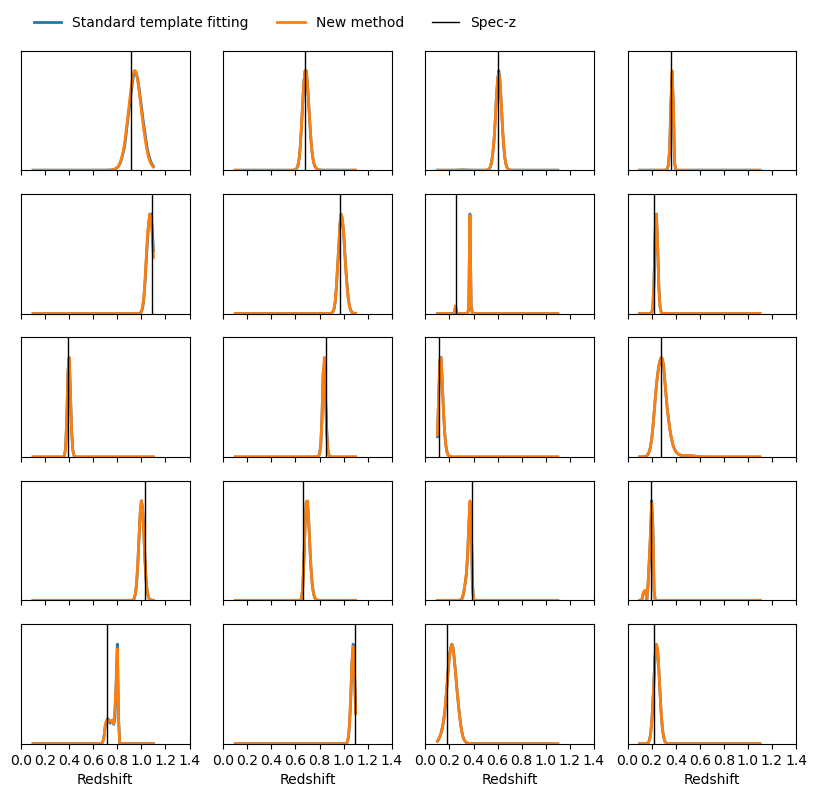

In [25]:
ncol = 4
fig, axs = plt.subplots(5, ncol, figsize=(10, 9), sharex=True, sharey=False)
axs = axs.ravel()
z = fluxredshifts[:, redshiftColumn]
sel = np.random.choice(nobj, axs.size, replace=False)
lw = 2
for ik in range(axs.size):
    k = sel[ik]
    print(k, end=" ")
    axs[ik].plot(redshiftGrid, pdfs_cww[k, :],lw=lw, label='Standard template fitting')# c="#2ecc71", 
    axs[ik].plot(redshiftGrid, pdfs[k, :], lw=lw, label='New method')  #, c="#3498db"
    axs[ik].axvline(fluxredshifts[k, redshiftColumn], c="k", lw=1, label='Spec-z')
    ymax = np.max(np.concatenate((pdfs[k, :], pdfs_cww[k, :])))
    axs[ik].set_ylim([0, ymax*1.2])
    axs[ik].set_xlim([0, 1.1])
    axs[ik].set_yticks([])
    axs[ik].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
for i in range(ncol):
    axs[-i-1].set_xlabel('Redshift', fontsize=10)
axs[0].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 1.4))
#fig.tight_layout()
#fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.96)


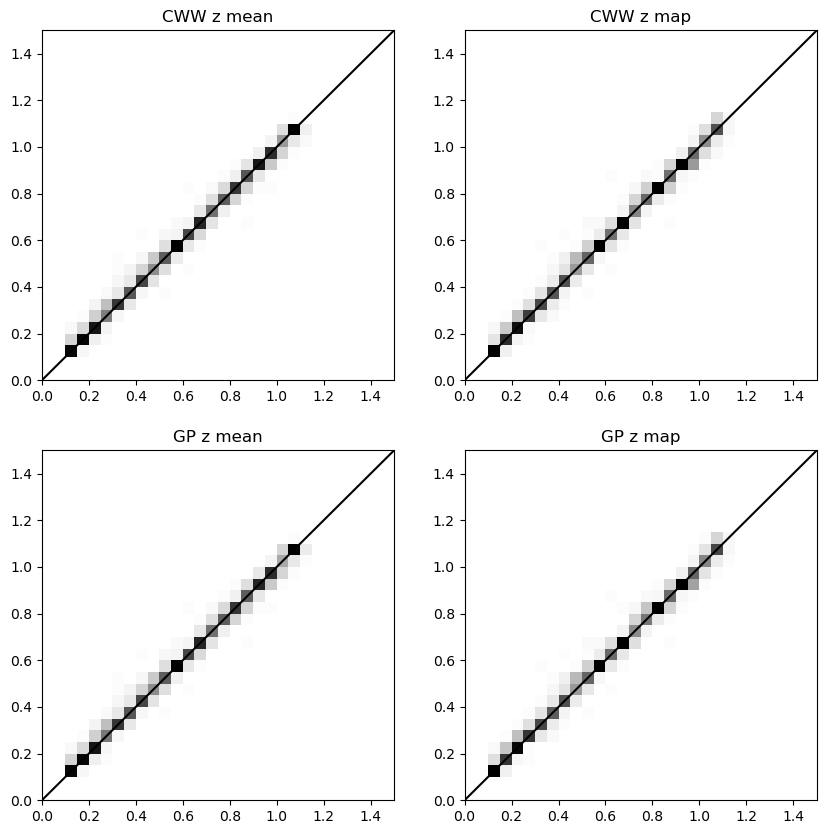

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
zmax = 1.5
rr = [[0, zmax], [0, zmax]]
nbins = 30
h = axs[0, 0].hist2d(metricscww[:, i_zt], metricscww[:, i_zm], nbins, cmap='Greys', range=rr)
hmin, hmax = np.min(h[0]), np.max(h[0])
axs[0, 0].set_title('CWW z mean')
axs[0, 1].hist2d(metricscww[:, i_zt], metricscww[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[0, 1].set_title('CWW z map')
axs[1, 0].hist2d(metrics[:, i_zt], metrics[:, i_zm], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 0].set_title('GP z mean')
axs[1, 1].hist2d(metrics[:, i_zt], metrics[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 1].set_title('GP z map')
axs[0, 0].plot([0, zmax], [0, zmax], c='k')
axs[0, 1].plot([0, zmax], [0, zmax], c='k')
axs[1, 0].plot([0, zmax], [0, zmax], c='k')
axs[1, 1].plot([0, zmax], [0, zmax], c='k')
#fig.tight_layout()

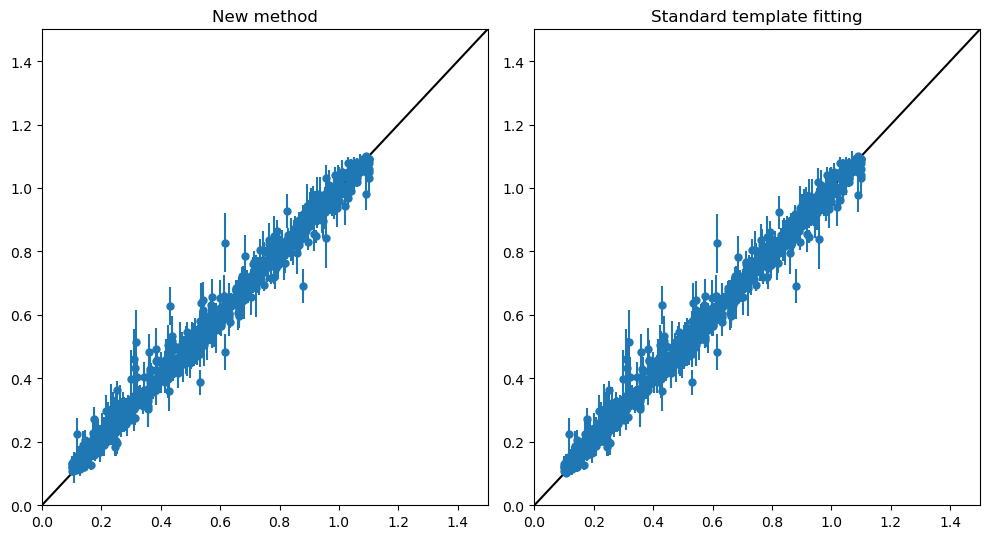

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5.5))
chi2s = ((metrics[:, i_zt] - metrics[:, i_ze])/metrics[:, i_std_ze])**2

axs[0].errorbar(metrics[:, i_zt], metrics[:, i_ze], yerr=metrics[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[1].errorbar(metricscww[:, i_zt], metricscww[:, i_ze], yerr=metricscww[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[0].plot([0, zmax], [0, zmax], 'k')
axs[1].plot([0, zmax], [0, zmax], 'k')
axs[0].set_xlim([0, zmax])
axs[1].set_xlim([0, zmax])
axs[0].set_ylim([0, zmax])
axs[1].set_ylim([0, zmax])
axs[0].set_title('New method')
axs[1].set_title('Standard template fitting')

fig.tight_layout()

Text(0.5, 1.0, 'New method')

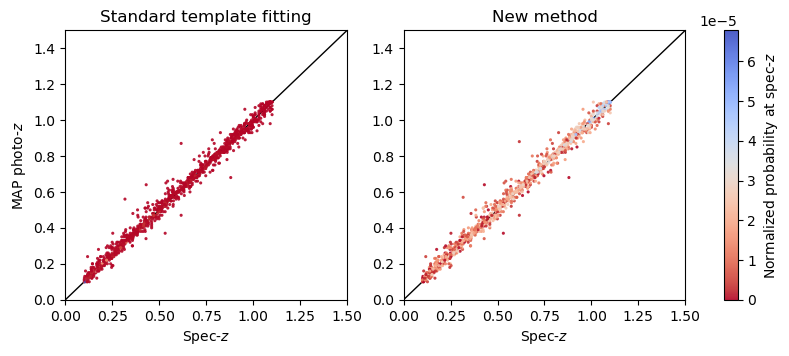

In [28]:
cmap = "coolwarm_r"
vmin = 0.0
alpha = 0.9
s = 5
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
vs = axs[0].scatter(metricscww[:, i_zt], metricscww[:, i_zmap], 
                    s=s, c=pdfatZ_cww, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
vs = axs[1].scatter(metrics[:, i_zt], metrics[:, i_zmap], 
                    s=s, c=pdfatZ, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
clb = plt.colorbar(vs, ax=axs.ravel().tolist())
clb.set_label('Normalized probability at spec-$z$')
for i in range(2):
    axs[i].plot([0, zmax], [0, zmax], c='k', lw=1, zorder=0, alpha=1)
    axs[i].set_ylim([0, zmax])
    axs[i].set_xlim([0, zmax])
    axs[i].set_xlabel('Spec-$z$')
axs[0].set_ylabel('MAP photo-$z$')

axs[0].set_title('Standard template fitting')
axs[1].set_title('New method')

## Conclusion
Don't be too harsh with the results of the standard template fitting or the new methods since both have a lot of parameters which can be optimized!

If the results above made sense, i.e. the redshifts are reasonnable for both methods on the mock data, then you can start modifying the parameter files and creating catalog files containing actual data! I recommend using less than 20k galaxies for training, and 1000 or 10k galaxies for the delight-apply script at the moment. Future updates will address this issue.